https://towardsdatascience.com/case-study-1-customer-satisfaction-prediction-on-olist-brazillian-dataset-4289bdd20076

https://github.com/Ashcom-git/case-study-1/blob/main/case_study_1_complete.ipynb

https://github.com/NoahPlage/Olist-Business-Analysis/blob/main/olist-notebook.ipynb

Recomiendo que revisemos este también
https://blog.jovian.ai/%EF%B8%8Fexploratory-data-analysis-eda-on-brazilian-e-commerce-olist-e3d2ce725d8b

Yo lo reviso e incluyo información de aquí


Y eset otro está muy interesante https://github.com/beto1810/E-commerce-Company

In [1]:
!apt-get install libgeos-dev
#!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6
!pip install fasttext
!python -m spacy download pt
!pip install tensorflow_addons
!pip install basemap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 2.5 MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp38-cp38-linux_x86_64.whl size=3724296 sha256=89cd18a99579f6978f91c6a00198b976ba14a819480b7ff56cf8001384d72e4f
  Stored in directory: /root/.cache/pip/wheels/88/f9/15/d2091255dc0aad51e9a83ab7293de72c5c42f5241fb8a9828c
Successfully built pyproj
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.7 MB/s 
  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import regex as re
from datetime import datetime
from tqdm import tqdm
import pickle
import scipy
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss
import fasttext.util
import warnings
from tensorflow_addons.metrics import F1Score
from sklearn.utils.extmath import randomized_svd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding, LSTM, Flatten, Concatenate, Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
from prettytable import PrettyTable
from keras.models import load_model
from sklearn.metrics import plot_confusion_matrix


warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

## Exploración, limpieza y transformación de los datos

Se realiza el cargue de los datos desde las 8 tablas que se encuentran cargadas en el Drive, las cuales corresponden a los datos descargados desde https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?resource=download

In [3]:
#Access drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


esta primera parte fue tomada de 

https://github.com/Ashcom-git/case-study-1/blob/main/case_study_1_complete.ipynb

In [4]:
# Reading all the files
#raw_path = '/content/drive/MyDrive/ColabNotebooks/06_MetodologiasAgiles/Project/output_folder/'
raw_path ='/content/drive/MyDrive/Colab Notebooks/06_MetodologiasAgiles/Project/output_folder/'
olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

A continuación se realiza la visualización y exploración de cada una de las tablas que componen la base de datos. Para cada tabla se visualiza la información, las primeras filas, el porcentaje de valores nulos. En algunas tablas debido a su contenido se realiza exploración de datos adicional. 

### 1. Olist_customer Dataset

In [5]:
olist_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [6]:
olist_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Se analiza el porcentaje de valores nulos.

In [7]:
olist_customer.isnull().mean()*100

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

In [8]:
olist_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


### 2. Olist_orders Dataset

In [9]:
olist_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [10]:
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [11]:
olist_orders.isnull().mean()*100

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.160899
order_delivered_carrier_date     1.793023
order_delivered_customer_date    2.981668
order_estimated_delivery_date    0.000000
dtype: float64

Los valores nulos son muy bajos. 

### 3. Olist_order_items Dataset

In [12]:
olist_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [13]:
olist_order_items.isnull().mean()*100

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

In [14]:
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
olist_order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


### 4. Olist_order_payments Dataset

In [16]:
olist_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [17]:
olist_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [18]:
olist_order_payments.isnull().mean()*100

order_id                0.0
payment_sequential      0.0
payment_type            0.0
payment_installments    0.0
payment_value           0.0
dtype: float64

De esta tabla se explora los tipos de pago registrados.

In [19]:
olist_order_payments['payment_type'].unique() 

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

### 5. Olist_order_reviews Dataset

In [20]:
olist_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [21]:
olist_order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [22]:
olist_order_reviews.isnull().mean()*100

review_id                   0.000000
order_id                    0.000000
review_score                0.000000
review_comment_title       88.341530
review_comment_message     58.702532
review_creation_date        0.000000
review_answer_timestamp     0.000000
dtype: float64

En esta tabla se observa un alto porcentaje de valores nulos en los campos de título y mensaje, dado que esta información es opcional, el campo obligatorio para que el cliente realice su reseña es la puntuación. 

A continuación se presenta el conteo de cada puntaje (1 a 5), registrado en la base de datos.

In [23]:
olist_order_reviews['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

### 6. Olist_products Dataset

In [24]:
olist_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [25]:
olist_products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [26]:
olist_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [27]:
olist_products.isnull().mean()*100

product_id                    0.000000
product_category_name         1.851234
product_name_lenght           1.851234
product_description_lenght    1.851234
product_photos_qty            1.851234
product_weight_g              0.006070
product_length_cm             0.006070
product_height_cm             0.006070
product_width_cm              0.006070
dtype: float64

Se verifica el tamaño de la información contenida en la columna 'product_weight_g' para asegurarnos de que no haya ninguna anomalía.

In [28]:
olist_products[olist_products['product_weight_g']== 0]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
9769,81781c0fed9fe1ad6e8c81fca1e1cb08,cama_mesa_banho,51.0,529.0,1.0,0.0,30.0,25.0,30.0
13683,8038040ee2a71048d4bdbbdc985b69ab,cama_mesa_banho,48.0,528.0,1.0,0.0,30.0,25.0,30.0
14997,36ba42dd187055e1fbe943b2d11430ca,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0
32079,e673e90efa65a5409ff4196c038bb5af,cama_mesa_banho,53.0,528.0,1.0,0.0,30.0,25.0,30.0


Se chequean los valores nulos de la columna 'product_categoy_name' y 'product_weight_g'

In [29]:
olist_products[olist_products['product_category_name'].isnull() == True]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [30]:
olist_products[olist_products['product_weight_g'].isnull() == True]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se procede a eliminar las filas de valores nulos, es importante tener en cuenta que son 610 registros, lo cual no es significativo respecto al total de entradas totales (32951).

In [95]:
olist_products = olist_products.dropna()  
olist_products.isnull().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

En la siguiente gráfica comprobamos la distribución de la columna product_weight_g

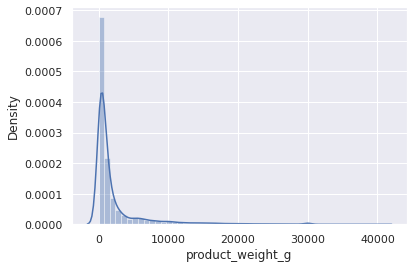

In [97]:
sns.distplot(olist_products['product_weight_g'])

### 7. Olist_sellers Dataset

In [38]:
olist_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [30]:
olist_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [81]:
olist_sellers.isnull().mean()*100

seller_id                 0.0
seller_zip_code_prefix    0.0
seller_city               0.0
seller_state              0.0
dtype: float64

### 8. Olist_geolocation Dataset

In [24]:
olist_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [75]:
olist_geolocation.isnull().mean()*100

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

Se realiza la visualización de los datos relacionados con la geolocalización de los compradores brasileños a través de un mapa. 

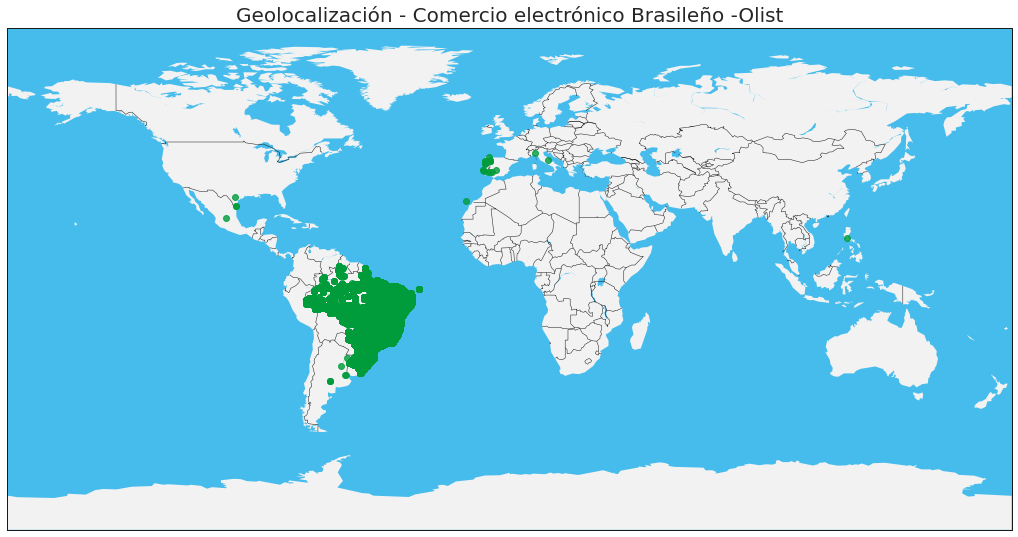

In [46]:
lat = olist_geolocation['geolocation_lat']
lon = olist_geolocation['geolocation_lng']

plt.figure(figsize=(18,18))

m = Basemap()
#dibuja un límite alrededor del mapa, rellena el fondo.
# este fondo terminará siendo el color del océano, ya que
# los continentes se dibujarán en la parte superior.
m.drawmapboundary(fill_color='#46bcec')
# fill continents, establece el color del lago igual que el color del océano.
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
# dibuja los límites de los países
m.drawcountries()
# dibuja puntos con marcadores
m.scatter(lon, lat, zorder=10, alpha=0.8, color='#009c3b')
# Se establece el título de la figura
plt.title(label='Geolocalización - Comercio electrónico Brasileño -Olist', fontsize=20)
plt.show()

En la gráfica se visualizan puntos ubicados en zonas geográficas diferentes a Brasil, la cual es nuestra región de interés, por lo tanto se remueven los registros que contienen observaciones fuera de dicha región. 

In [47]:
# El punto más septentrional de Brasil está a 5 grados 16′ 27,8″ de latitud norte.
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
# El punto más occidental de Brasil está a 73 grados, 58′ 58.19″W Long
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lng >= -73.98283055]
# El punto más al sur de Brasil está a 33 grados, 45′ 04.21″ S Latitud
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lat >= -33.75116944]
# El lugar más oriental de Brasil es 34 grados, 47 ′ 35.33 ″ W Long.
olist_geolocation = olist_geolocation[olist_geolocation.geolocation_lng <=  -34.79314722]

Se realiza nuevamente la visualización del mapa, observándose solo los puntos en la región de interés. 

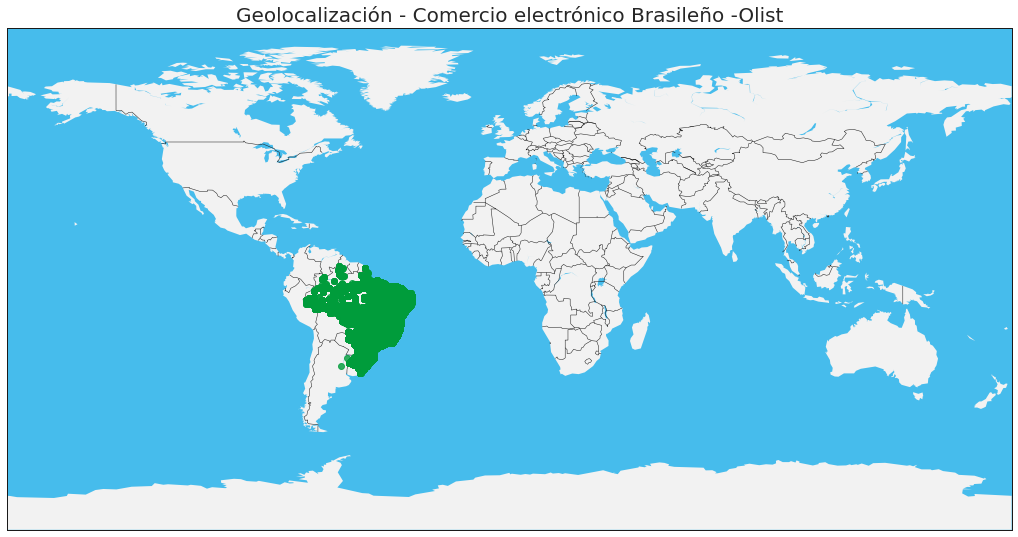

In [48]:
lat = olist_geolocation['geolocation_lat']
lon = olist_geolocation['geolocation_lng']

plt.figure(figsize=(18,18))

m = Basemap()
#dibuja un límite alrededor del mapa, rellena el fondo.
# este fondo terminará siendo el color del océano, ya que
# los continentes se dibujarán en la parte superior.
m.drawmapboundary(fill_color='#46bcec')
# fill continents, establece el color del lago igual que el color del océano.
m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
# dibuja los límites de los países
m.drawcountries()
# dibuja puntos con marcadores
m.scatter(lon, lat, zorder=10, alpha=0.8, color='#009c3b')
# Se establece el título de la figura
plt.title(label='Geolocalización - Comercio electrónico Brasileño -Olist', fontsize=20)
plt.show()

### DataFrame: exploración del conjunto de datos

A continuación se crea un dataframe a partir de la fusión de tablas que contienen información relacionada. Por ejemplo, la tabla olist_order_items que contiene la información sobre detalles del artículo de compra, fecha de envío, el precio, entre otros, se fusiona con la tabla olist_products la cual contiene la identificación del producto como el ID, categoría y medidas.

In [66]:
order_items_products = pd.merge(olist_order_items,olist_products, on='product_id')
order_items_products_sellers = pd.merge(order_items_products,olist_sellers,on='seller_id')
two_order_items_products_sellers = pd.merge(order_items_products_sellers,olist_orders,on='order_id')
two_order_items_products_sellers_customer = pd.merge(two_order_items_products_sellers,olist_customer,on='customer_id')
two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,olist_order_reviews,on='order_id')
final_dataframe = pd.merge(two_order_items_products_sellers_customer_reviews,olist_order_payments,on='order_id')

In [67]:
order_items_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_id                    112650 non-null  object 
 1   order_item_id               112650 non-null  int64  
 2   product_id                  112650 non-null  object 
 3   seller_id                   112650 non-null  object 
 4   shipping_limit_date         112650 non-null  object 
 5   price                       112650 non-null  float64
 6   freight_value               112650 non-null  float64
 7   product_category_name       111047 non-null  object 
 8   product_name_lenght         111047 non-null  float64
 9   product_description_lenght  111047 non-null  float64
 10  product_photos_qty          111047 non-null  float64
 11  product_weight_g            112632 non-null  float64
 12  product_length_cm           112632 non-null  float64
 13  product_height

In [53]:
# se supone que esta línea de código sirve para traducir de portugues a ingles pero creo que no tenemos disponible el archivo de traducción

#mapping = dict(zip(product_category_name_translation['product_category_name'].tolist(),product_category_name_translation['product_category_name_english'].tolist()))
#final_dataframe['product_category_name'] = final_dataframe['product_category_name'].map(mapping)

In [68]:
final_dataframe.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,1,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,1,credit_card,2,83.23


In [69]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   order_item_id                  117329 non-null  int64  
 2   product_id                     117329 non-null  object 
 3   seller_id                      117329 non-null  object 
 4   shipping_limit_date            117329 non-null  object 
 5   price                          117329 non-null  float64
 6   freight_value                  117329 non-null  float64
 7   product_category_name          115634 non-null  object 
 8   product_name_lenght            115634 non-null  float64
 9   product_description_lenght     115634 non-null  float64
 10  product_photos_qty             115634 non-null  float64
 11  product_weight_g               117309 non-null  float64
 12  product_length_cm             

In [70]:
print(final_dataframe.columns)
final_dataframe.shape

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


(117329, 39)

In [71]:
final_dataframe = final_dataframe.drop_duplicates(subset=['order_id','order_purchase_timestamp','product_id','customer_unique_id','review_comment_message'])
final_dataframe.shape

(101878, 39)

In [72]:
final_dataframe.drop(['order_id','product_id','seller_id','customer_unique_id'], axis=1, inplace=True)
final_dataframe.columns

Index(['order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

In [ ]:
final_dataframe['product_category_name'].fillna(value=final_dataframe['product_category_name'].mode()[0], inplace=True)
final_dataframe['product_name_lenght'].fillna(value=final_dataframe['product_name_lenght'].mode()[0], inplace=True)
final_dataframe['product_description_lenght'].fillna(value=final_dataframe['product_description_lenght'].median(), inplace=True)
final_dataframe['product_photos_qty'].fillna(value=final_dataframe['product_photos_qty'].mode()[0], inplace=True)
final_dataframe['product_weight_g'].fillna(value=final_dataframe['product_weight_g'].mode()[0], inplace=True)
final_dataframe['product_length_cm'].fillna(value=final_dataframe['product_length_cm'].mode()[0], inplace=True)
final_dataframe['product_height_cm'].fillna(value=final_dataframe['product_height_cm'].mode()[0], inplace=True)
final_dataframe['product_width_cm'].fillna(value=final_dataframe['product_width_cm'].mode()[0], inplace=True)
final_dataframe['review_comment_message'].fillna(value='indisponível', inplace=True)

In [ ]:
final_dataframe['review_score'] = final_dataframe['review_score'].apply(lambda x: 1 if x > 3 else 0)

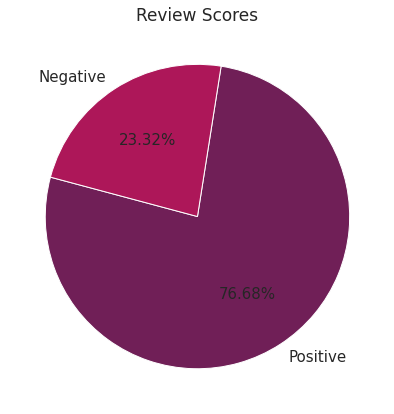

In [ ]:
plt.figure(figsize=(7,7))
final_dataframe['review_score'].map({0:'Negative',1:'Positive'}).value_counts().plot.pie(autopct='%.2f%%', textprops={'fontsize':15}, startangle=165, colors=['#701f57','#ad1759','#f6b48f'])
plt.title('Review Scores', fontsize=17)
plt.ylabel('')
plt.show()

In [ ]:
final_dataframe[['price','freight_value','product_name_lenght','product_description_lenght','product_weight_g','product_length_cm', 'product_height_cm', 'product_height_cm',	'product_width_cm']].describe()

,price,freight_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_height_cm,product_width_cm
count,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000,101878.000000
mean,124.206951,20.105371,49.022154,784.166032,2088.324437,30.076415,16.397780,16.397780,23.037103
std,187.508494,15.871753,9.995155,646.060701,3749.141203,16.086989,13.304443,13.304443,11.744047
min,0.850000,0.000000,5.000000,4.000000,0.000000,7.000000,2.000000,2.000000,6.000000
25%,40.000000,13.140000,43.000000,348.000000,300.000000,18.000000,8.000000,8.000000,15.000000
50%,78.720000,16.320000,52.000000,602.000000,696.000000,25.000000,13.000000,13.000000,20.000000
75%,139.000000,21.200000,57.000000,980.000000,1800.000000,38.000000,20.000000,20.000000,30.000000
max,6735.000000,409.680000,76.000000,3992.000000,40425.000000,105.000000,105.000000,105.000000,118.000000


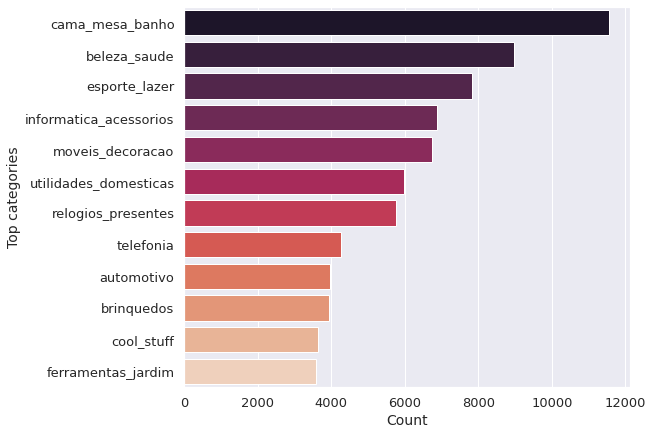

In [ ]:
plt.figure(figsize=(8,7))
idx = final_dataframe['product_category_name'].value_counts()[:12].index
sns.countplot(y=final_dataframe['product_category_name'], order=idx, palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

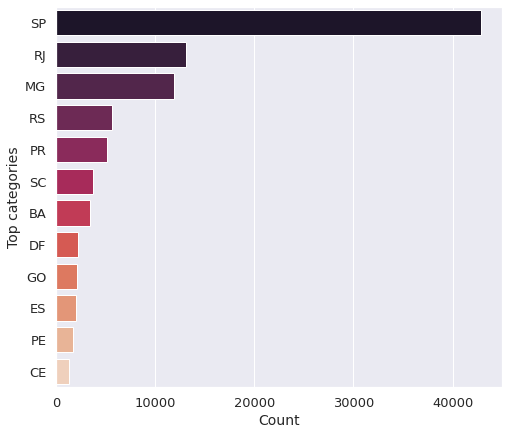

In [ ]:
plt.figure(figsize=(8,7))
idx = final_dataframe['customer_state'].value_counts()[:12].index
sns.countplot(y=final_dataframe['customer_state'], order=idx, palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

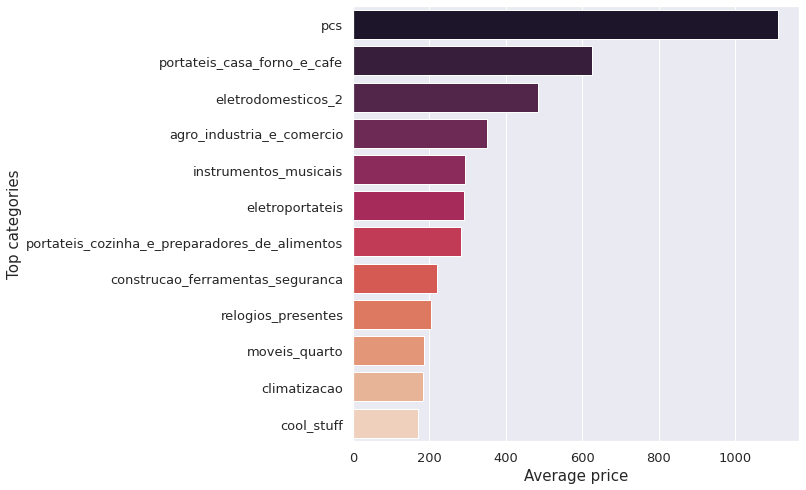

In [ ]:
grp_cat_name = final_dataframe.groupby('product_category_name')
grp_dict = dict(grp_cat_name.mean()['price'].sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

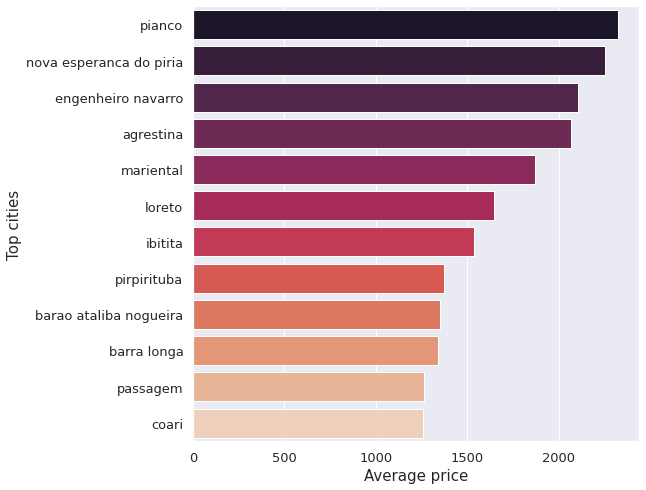

In [ ]:
grp_state_name = final_dataframe.groupby('customer_city')
grp_dict = dict((grp_state_name.mean()['price']+grp_state_name.mean()['freight_value']).sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top cities', fontsize=15)
plt.show()

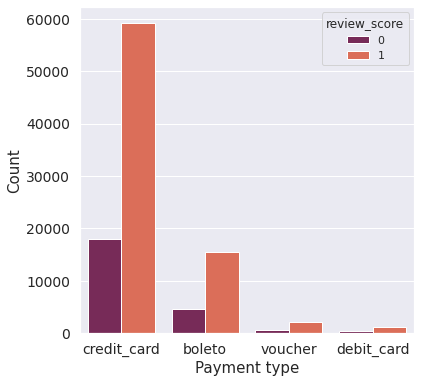

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(data=final_dataframe,x='payment_type', hue='review_score', palette='rocket')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Payment type', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

## Preprocesamiento 

Tomado de https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

In [ ]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


In [ ]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]
    
    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """
    
    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1
        
    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """
    
    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

In [ ]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [ ]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

In [ ]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

In [ ]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26665])

--- Text 1 ---

Before: 
Ainda não chegou , vou esperar até o dia 26, prazo que me foi dado. Duas estrelas, só por enquanto.

After: 
Ainda não chegou , vou esperar até o dia 26, prazo que me foi dado. Duas estrelas, só por enquanto.



In [ ]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[26020, 33297, 32998])

In [ ]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.

After: 
Comprei o produto dia  numero  de fevereiro e hoje dia  numero  de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.



In [ ]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[4783, 4627, 4856, 4904])

In [ ]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [ ]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 135, 234])

In [ ]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [ ]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

In [ ]:
# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

In [ ]:
# Examples of some portuguese stopwords
import nltk
nltk.download('stopwords')
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [ ]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [ ]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado

After: 
recebi bem antes prazo estipulado

--- Text 2 ---

Before: 
Este foi o pedido Balde Com numero Peças Blocos De Montar numero un dinheiro cada negação FOI ENTREGUE Vendido e entregue targaryen Tapete de Eva Nº Letras numero Peças Crianças numero un dinheiro ESTE FOI ENTREG

After: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

--- Text 3 ---

Before: 
Chegou um pouco antes do prazo isso é bom

After: 
chegou pouco antes prazo bom



In [ ]:
# Defining a function to remove the stopwords and to lower the comments
import nltk
nltk.download('rslp')
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
recebi bem antes prazo estipulado

After: 
receb bem ant praz estipul

--- Text 2 ---

Before: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

After: 
ped bald numer peç bloc mont numer un dinh cad neg entreg vend entreg targaryen tapet eva nº letr numer peç crianç numer un dinh entreg

--- Text 3 ---

Before: 
produto chegou ja devolver pois defeito negação segurar carga

After: 
produt cheg ja devolv poi defeit neg segur carg



## Extracción de caracteristicas

Tomado de https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp


El problema de este código es que usa unas librerias que ellos crearon, estan disponibles en la página pero no se como subirlas aca. Se puede hacer todo menos los gráficos.

Si logramos solucionar el tema de las librerias propias se puede correr todo el código


In [ ]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

In [ ]:
# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (40977, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Creating an object for the CountVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (40977, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.319302,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.196792,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.461052,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


etiquetado

In [ ]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)


In [ ]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [ ]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

In [ ]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

pipeline

In [ ]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [ ]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

In [ ]:
# Defining X and y 
idx_reviews = olist_order_reviews['review_comment_message'].dropna().index
score = olist_order_reviews['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviews['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


## Clasificación de sentimientos

In [ ]:
# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [ ]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [ ]:
# de aqui para abajo no me funciona el código
# BinaryClassifiersAnalysis esta en una libreria de ellos que se llama ml_utils

# Creating an object and training the classifiers
#clf_tool = BinaryClassifiersAnalysis()
#clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')

In [ ]:
# Evaluating metrics
#df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test, cv=5)
#df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')

In [ ]:
#clf_tool.plot_confusion_matrix(classes=['Negative', 'Positive'])

Implementación final 

In [ ]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

tomado de https://github.com/Ashcom-git/case-study-1/blob/main/case_study_1_complete.ipynb

linea 35

El problma de este código es que depende de un archivo que no esta disponible cc.pt.300.bin

Hay algunas particiones que no funcionan

In [ ]:
labels = final_dataframe['review_score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_dataframe, labels, stratify=labels, test_size=0.2, random_state=0)

In [ ]:
def train_response(frame):
  f1 = frame[frame.iloc[:,1] == 0]
  f2 = frame[frame.iloc[:,1] == 1]
  global dict_frame, dict_f1, dict_f2
  dict_frame = dict(frame.iloc[:,0].value_counts())
  dict_f1 = dict(f1.iloc[:,0].value_counts())
  dict_f2 = dict(f2.iloc[:,0].value_counts())
  state_0, state_1 = [],[],
  for i in range(len(frame)):
    if frame.iloc[:,1][i] == 0:
      state_0.append(dict_f1.get(frame.iloc[:,0][i],0)/dict_frame[frame.iloc[:,0][i]])
      state_1.append(float(1-state_0[-1]))
    else:
      state_1.append(dict_f2.get(frame.iloc[:,0][i],0)/dict_frame[frame.iloc[:,0][i]])
      state_0.append(float(1-state_1[-1])) 
  df3 = pd.DataFrame({'State_0':state_0, 'State_1':state_1})
  return df3.to_numpy()

def test_response(test):
  t_state_0, t_state_1 = [],[]
  for i in range(len(test)):
    if dict_frame.get(test[i]):
      t_state_0.append(dict_f1.get(test[i],0)/dict_frame.get(test[i]))
      t_state_1.append(dict_f2.get(test[i],0)/dict_frame.get(test[i]))
    else:
      t_state_0.append(0.5)
      t_state_1.append(0.5)
  df4 = pd.DataFrame({'State_0':t_state_0, 'State_1':t_state_1})
  return df4.to_numpy()  

In [ ]:
X_train_resp_prod_cat = train_response(pd.concat([X_train['product_category_name'], y_train], axis=1).reset_index(drop=True))
X_test_resp_prod_cat = test_response(X_test['product_category_name'].values)

In [ ]:
# No funciona este código 

#ohe_order_item = OneHotEncoder()
#ohe_order_item.fit(X_train['order_item_id'].values.reshape(-1,1))
#X_train_order_item = ohe_order_item.transform(X_train['order_item_id'].values.reshape(-1,1)).toarray()
#X_test_order_item = ohe_order_item.transform(X_test['order_item_id'].values.reshape(-1,1)).toarray()

In [ ]:
X_train_resp_payment_seq = train_response(pd.concat([X_train['payment_sequential'], y_train], axis=1).reset_index(drop=True))
X_test_resp_payment_seq = test_response(X_test['payment_sequential'].values)

In [ ]:
ohe_payment_type = OneHotEncoder()
ohe_payment_type.fit(X_train['payment_type'].values.reshape(-1,1))
X_train_payment_type = ohe_payment_type.transform(X_train['payment_type'].values.reshape(-1,1)).toarray()
X_test_payment_type = ohe_payment_type.transform(X_test['payment_type'].values.reshape(-1,1)).toarray()